# I. Import libraries

In [21]:
#Import libraries
import pandas as pd 
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Pandas configurations 
sns.set()
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

# II. Import dataset

In [3]:
#Import data
print('Loading data...')

train_2016 = pd.read_csv('/home/apprenant/Documents/simplon_dev/pyhon_sql/zillow_price/Data/raw_data/train_2016_v2.csv', low_memory=False)
properties_2016 = pd.read_csv('/home/apprenant/Documents/simplon_dev/pyhon_sql/zillow_price/Data/raw_data/properties_2016.csv',low_memory=False) 
train_2017 = pd.read_csv('/home/apprenant/Documents/simplon_dev/pyhon_sql/zillow_price/Data/raw_data/train_2017.csv',low_memory=False)
properties_2017 = pd.read_csv('/home/apprenant/Documents/simplon_dev/pyhon_sql/zillow_price/Data/raw_data/properties_2017.csv',low_memory=False) 

Loading data...


# III. Data exploratory

## III.1 Merging the data

In [4]:
#Merging properties with the train dataset for exploratory analysis
print('Merging the data...')

df_train_2016 = train_2016.merge(properties_2016, how='left', on='parcelid')
df_train_2017 = train_2017.merge(properties_2017, how='left', on='parcelid')

full_df = pd.concat([df_train_2017,df_train_2016])
#Check the train dataset
print('Our dataset contains {} rows and {} columns.'.format(full_df.shape[0], full_df.shape[1]))

Merging the data...
Our dataset contains 167888 rows and 60 columns.


## III.2 Data analysis

### III.2.1 Data type check

We can see that most of our data are numerical values


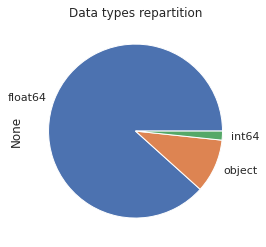

In [5]:
# Just as informations about our data types
sns.set_theme(style="whitegrid")
plt.title('Data types repartition')
full_df.dtypes.value_counts().plot.pie()
print('We can see that most of our data are numerical values')

### III.2.2 Dataset columns

In [6]:
full_df.columns

Index(['parcelid', 'logerror', 'transactiondate', 'airconditioningtypeid',
       'architecturalstyletypeid', 'basementsqft', 'bathroomcnt', 'bedroomcnt',
       'buildingclasstypeid', 'buildingqualitytypeid', 'calculatedbathnbr',
       'decktypeid', 'finishedfloor1squarefeet',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12',
       'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50',
       'finishedsquarefeet6', 'fips', 'fireplacecnt', 'fullbathcnt',
       'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcn

Renaming columns for better understanding of our features as they are a bit confusing at first

In [7]:
"""
    Assign better names to all feature columns of 'properties' table
"""
def rename_columns(df):
     df.rename(columns={
          'parcelid': 'parcelid',  # Unique identifier of parcels
          'airconditioningtypeid': 'cooling_id',  # type of cooling system (if any), 1~13
          'architecturalstyletypeid': 'architecture_style_id',  # Architectural style of the home, 1~27
          'basementsqft': 'basement_sqft',  # Size of the basement
          'bathroomcnt': 'bathroom_cnt',  # Number of bathrooms (including fractional bathrooms)
          'bedroomcnt': 'bedroom_cnt',  # Number of bedrooms
          'buildingclasstypeid': 'framing_id',  # The building framing type, 1~5
          'buildingqualitytypeid': 'quality_id',  # building condition from best (lowest) to worst (highest)
          'calculatedbathnbr': 'bathroom_cnt_calc',  # Same meaning as 'bathroom_cnt'?
          'decktypeid': 'deck_id',  # Type of deck (if any)
          'finishedfloor1squarefeet': 'floor1_sqft',  # Size of finished living area on first floor
          'calculatedfinishedsquarefeet': 'finished_area_sqft_calc',  # calculated total finished living area
          'finishedsquarefeet12': 'finished_area_sqft',  # Same meaning as 'finished_area_sqft_calc'?
          'finishedsquarefeet13': 'perimeter_area',  # Perimeter living area
          'finishedsquarefeet15': 'total_area',  # Total area
          'finishedsquarefeet50': 'floor1_sqft_unk',  # Same meaning as 'floor1_sqft'?
          'finishedsquarefeet6': 'base_total_area',  # Base unfinished and finished area
          'fips': 'fips',  # Federal Information Processing Standard code
          'fireplacecnt': 'fireplace_cnt',  # Number of fireplaces in the home (if any)
          'fullbathcnt': 'bathroom_full_cnt',  # Number of full bathrooms
          'garagecarcnt': 'garage_cnt',  # Total number of garages
          'garagetotalsqft': 'garage_sqft',  # Total size of the garages
          'hashottuborspa': 'spa_flag',  # Whether the home has a hot tub or spa
          'heatingorsystemtypeid': 'heating_id',  # type of heating system, 1~25
          'latitude': 'latitude',  # latitude of the middle of the parcel multiplied by 1e6
          'longitude': 'longitude',  # longitude of the middle of the parcel multiplied by 1e6
          'lotsizesquarefeet': 'lot_sqft',  # Area of the lot in sqft
          'poolcnt': 'pool_cnt', # Number of pools in the lot (if any)
          'poolsizesum': 'pool_total_size',  # Total size of the pools
          'pooltypeid10': 'pool_unk_1',
          'pooltypeid2': 'pool_unk_2',
          'pooltypeid7': 'pool_unk_3',
          'propertycountylandusecode': 'county_landuse_code',
          'propertylandusetypeid': 'landuse_type_id' ,  # Type of land use the property is zoned for, 25 categories
          'propertyzoningdesc': 'zoning_description',  # Allowed land uses (zoning) for that property
          'rawcensustractandblock': 'census_1',
          'regionidcity': 'city_id',  # City in which the property is located (if any)
          'regionidcounty': 'county_id',  # County in which the property is located
          'regionidneighborhood': 'neighborhood_id',  # Neighborhood in which the property is located
          'regionidzip': 'region_zip',
          'roomcnt': 'room_cnt',  # Total number of rooms in the principal residence
          'storytypeid': 'story_id',  # Type of floors in a multi-story house, 1~35
          'threequarterbathnbr': 'bathroom_small_cnt',  # Number of 3/4 bathrooms
          'typeconstructiontypeid': 'construction_id',  # Type of construction material, 1~18
          'unitcnt': 'unit_cnt',  # Number of units the structure is built into (2=duplex, 3=triplex, etc)
          'yardbuildingsqft17': 'patio_sqft',  # Patio in yard
          'yardbuildingsqft26': 'storage_sqft',  # Storage shed/building in yard
          'yearbuilt': 'year_built',  # The year the principal residence was built
          'numberofstories': 'story_cnt',  # Number of stories or levels the home has
          'fireplaceflag': 'fireplace_flag',  # Whether the home has a fireplace
          'structuretaxvaluedollarcnt': 'tax_structure',
          'taxvaluedollarcnt': 'tax_parcel',
          'assessmentyear': 'tax_year',  # The year of the property tax assessment (2015 for 2016 data)
          'landtaxvaluedollarcnt': 'tax_land',
          'taxamount': 'tax_property',
          'taxdelinquencyflag': 'tax_overdue_flag',  # Property taxes are past due as of 2015
          'taxdelinquencyyear': 'tax_overdue_year',  # Year for which the unpaid propert taxes were due
          'censustractandblock': 'census_2'
     }, inplace=True)
        
rename_columns(full_df)

In [8]:
full_df = full_df.drop('parcelid', axis=1)

In [9]:
full_df.head()

,logerror,transactiondate,cooling_id,architecture_style_id,basement_sqft,bathroom_cnt,bedroom_cnt,framing_id,quality_id,bathroom_cnt_calc,deck_id,floor1_sqft,finished_area_sqft_calc,finished_area_sqft,perimeter_area,total_area,floor1_sqft_unk,base_total_area,fips,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,latitude,longitude,lot_sqft,pool_cnt,pool_total_size,pool_unk_1,pool_unk_2,pool_unk_3,county_landuse_code,landuse_type_id,zoning_description,census_1,city_id,county_id,neighborhood_id,region_zip,room_cnt,story_id,bathroom_small_cnt,construction_id,unit_cnt,patio_sqft,storage_sqft,year_built,story_cnt,fireplace_flag,tax_structure,tax_parcel,tax_year,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2
0,0.03,2017-01-01,NaN,NaN,NaN,3.50,4.00,NaN,NaN,3.50,NaN,NaN,3100.00,3100.00,NaN,NaN,NaN,NaN,6059.00,NaN,3.00,2.00,633.00,NaN,NaN,33634931.00,-117869207.00,4506.00,NaN,NaN,NaN,NaN,NaN,122,261.00,NaN,60590630.07,53571.00,1286.00,NaN,96978.00,0.00,NaN,1.00,NaN,NaN,NaN,NaN,1998.00,NaN,NaN,485713.00,1023282.00,2016.00,537569.00,11013.72,NaN,NaN,60590630072012.00
1,0.06,2017-01-01,NaN,NaN,NaN,1.00,2.00,NaN,NaN,1.00,NaN,1465.00,1465.00,1465.00,NaN,NaN,1465.00,NaN,6111.00,1.00,1.00,1.00,0.00,NaN,NaN,34449266.00,-119281531.00,12647.00,NaN,NaN,NaN,NaN,NaN,1110,261.00,NaN,61110010.02,13091.00,2061.00,NaN,97099.00,5.00,NaN,NaN,NaN,NaN,NaN,NaN,1967.00,1.00,NaN,88000.00,464000.00,2016.00,376000.00,5672.48,NaN,NaN,61110010023006.00
2,0.01,2017-01-01,NaN,NaN,NaN,2.00,3.00,NaN,NaN,2.00,NaN,NaN,1243.00,1243.00,NaN,NaN,NaN,NaN,6059.00,NaN,2.00,2.00,440.00,NaN,NaN,33886168.00,-117823170.00,8432.00,1.00,NaN,NaN,NaN,1.00,122,261.00,NaN,60590218.02,21412.00,1286.00,NaN,97078.00,6.00,NaN,NaN,NaN,NaN,NaN,NaN,1962.00,1.00,NaN,85289.00,564778.00,2016.00,479489.00,6488.30,NaN,NaN,60590218022012.00
3,-0.10,2017-01-01,NaN,NaN,NaN,3.00,4.00,NaN,8.00,3.00,NaN,NaN,2376.00,2376.00,NaN,NaN,NaN,NaN,6037.00,NaN,3.00,NaN,NaN,NaN,2.00,34245180.00,-118240722.00,13038.00,1.00,NaN,NaN,NaN,1.00,0101,261.00,LCR110000*,60373001.00,396551.00,3101.00,NaN,96330.00,0.00,NaN,NaN,NaN,1.00,NaN,NaN,1970.00,NaN,NaN,108918.00,145143.00,2016.00,36225.00,1777.51,NaN,NaN,60373001001006.00
4,0.01,2017-01-01,1.00,NaN,NaN,3.00,3.00,NaN,8.00,3.00,NaN,NaN,1312.00,1312.00,NaN,NaN,NaN,NaN,6037.00,NaN,3.00,NaN,NaN,NaN,2.00,34185120.00,-118414640.00,278581.00,1.00,NaN,NaN,NaN,1.00,010C,266.00,LAR3,60371236.01,12447.00,3101.00,268548.00,96451.00,0.00,NaN,NaN,NaN,1.00,NaN,NaN,1964.00,NaN,NaN,73681.00,119407.00,2016.00,45726.00,1533.89,NaN,NaN,60371236012000.00


### III.2.3 Missing Values checks

Text(0.5, 0, 'percentage')

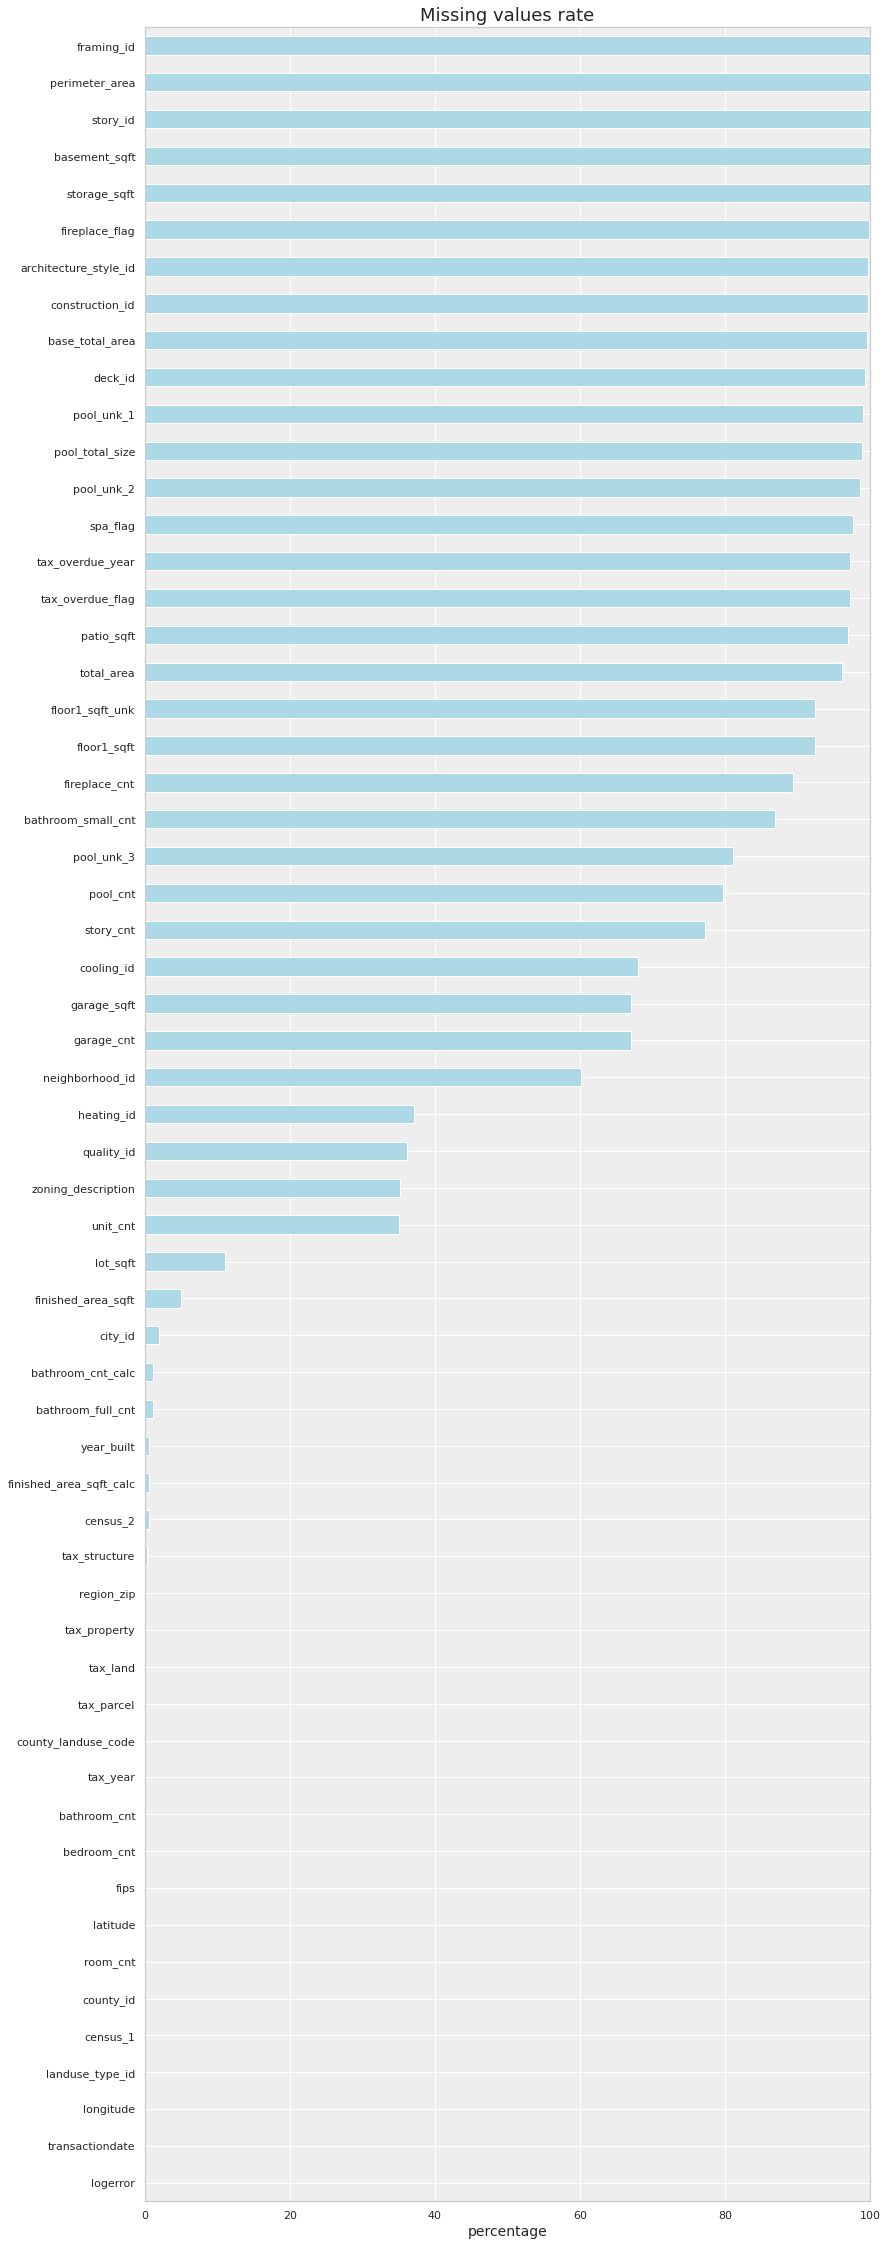

In [10]:
# Visualization of the  missing value per columns
plt.figure(figsize=(13, 40))
plt.rcParams['axes.facecolor'] = '#eee'
plt.rc('grid', color='#fff')
(full_df.isnull().mean(axis=0)*100).sort_values().plot.barh(color ="Lightblue")
plt.xlim(xmax=100)
plt.title("Missing values rate",fontsize=18)
plt.xlabel("percentage",fontsize=14)

We notice there are a lot of columns with more than 90 % missing values.
Let's check if our target variable has missing values.

In [11]:
print('Our target variable "logerror" has {} missing value(s)'.format(full_df['logerror'].isnull().sum()))

Our target variable "logerror" has 0 missing value(s)


# IV. Splitting the dataset into the train set and the test set

In [12]:
y = full_df['logerror']
X = full_df.drop(['logerror', 'transactiondate', 'county_landuse_code', 'zoning_description'], axis=1)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (167888, 55)
y shape: (167888,)


For preprocessing purpose, I identify the numerical and object columns.

In [28]:
numeric_cols = X.select_dtypes(include=["float64","int64"]).columns
category_cols = X.select_dtypes(include="object").columns

In [15]:
for col in category_cols:
    print("Unique values of the column {} : {}".format(col, X[col].unique()))
    print("Unique values of the column {} : {}".format(col, X[col].nunique(dropna=True)))

Unique values of the column spa_flag : [nan True]
Unique values of the column spa_flag : 1
Unique values of the column fireplace_flag : [nan True]
Unique values of the column fireplace_flag : 1
Unique values of the column tax_overdue_flag : [nan 'Y']
Unique values of the column tax_overdue_flag : 1


Since spa_flag, fireplace_flag and tax_overdue_flag have only one unique value and it's either True or 'Y', we could replace the missing values with False when the unique value is True and 'N' when the unique value is 'Y'.

In [29]:
X[['spa_flag', 'fireplace_flag']] = X[['spa_flag', 'fireplace_flag']].fillna(False)
X['tax_overdue_flag'] = X['tax_overdue_flag'].fillna('N')

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (134310, 55)
y_train shape: (134310,)
X_test shape: (33578, 55)
y_test shape: (33578,)


In [31]:
X_train.head()

,cooling_id,architecture_style_id,basement_sqft,bathroom_cnt,bedroom_cnt,framing_id,quality_id,bathroom_cnt_calc,deck_id,floor1_sqft,finished_area_sqft_calc,finished_area_sqft,perimeter_area,total_area,floor1_sqft_unk,base_total_area,fips,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,latitude,longitude,lot_sqft,pool_cnt,pool_total_size,pool_unk_1,pool_unk_2,pool_unk_3,landuse_type_id,census_1,city_id,county_id,neighborhood_id,region_zip,room_cnt,story_id,bathroom_small_cnt,construction_id,unit_cnt,patio_sqft,storage_sqft,year_built,story_cnt,fireplace_flag,tax_structure,tax_parcel,tax_year,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2
21667,1.00,NaN,NaN,2.00,3.00,NaN,7.00,2.00,NaN,NaN,1546.00,1546.00,NaN,NaN,NaN,NaN,6037.00,NaN,2.00,NaN,NaN,False,2.00,34453860.00,-118528669.00,6634.00,NaN,NaN,NaN,NaN,NaN,261.00,60379200.18,54311.00,3101.00,6952.00,96373.00,0.00,NaN,NaN,NaN,1.00,NaN,NaN,1985.00,NaN,False,219158.00,360455.00,2015.00,141297.00,5108.15,N,NaN,60379200181003.00
18789,NaN,NaN,NaN,3.00,6.00,NaN,7.00,3.00,NaN,NaN,2275.00,NaN,NaN,2275.00,NaN,NaN,6037.00,NaN,3.00,NaN,NaN,False,NaN,34054361.00,-118178843.00,5967.00,NaN,NaN,NaN,NaN,NaN,247.00,60375308.02,17882.00,3101.00,NaN,96044.00,0.00,NaN,NaN,NaN,3.00,NaN,NaN,1948.00,NaN,False,123511.00,268503.00,2015.00,144992.00,4538.13,N,NaN,60375308022019.00
38340,1.00,NaN,NaN,2.00,2.00,NaN,7.00,2.00,NaN,NaN,980.00,980.00,NaN,NaN,NaN,NaN,6037.00,NaN,2.00,NaN,NaN,False,2.00,34402900.00,-118464000.00,78027.00,1.00,NaN,NaN,NaN,1.00,266.00,60379200.42,54311.00,3101.00,26134.00,96352.00,0.00,NaN,NaN,NaN,1.00,NaN,NaN,1990.00,NaN,False,69192.00,181078.00,2015.00,111886.00,2715.39,N,NaN,60379200424005.00
87736,NaN,NaN,NaN,3.00,4.00,NaN,NaN,3.00,NaN,NaN,1863.00,1863.00,NaN,NaN,NaN,NaN,6059.00,NaN,3.00,2.00,453.00,False,NaN,33684570.00,-117648186.00,4400.00,NaN,NaN,NaN,NaN,NaN,261.00,60590524.27,32380.00,1286.00,NaN,96946.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,1992.00,NaN,False,212326.00,327674.00,2015.00,115348.00,4113.76,N,NaN,60590524271001.00
44896,NaN,NaN,NaN,2.50,3.00,NaN,NaN,2.50,NaN,NaN,1511.00,1511.00,NaN,NaN,NaN,NaN,6059.00,NaN,2.00,2.00,0.00,False,NaN,33560860.00,-117646873.00,NaN,NaN,NaN,NaN,NaN,NaN,266.00,60590320.57,52835.00,1286.00,764102.00,96998.00,0.00,NaN,1.00,NaN,NaN,NaN,NaN,2000.00,NaN,False,174087.00,417797.00,2015.00,243710.00,6197.28,N,NaN,60590320573008.00


# V. RandomForest model

## V.1 Imputing missing values for numerical and categorical variables

In [32]:
# Preprocessing data
num_imp = SimpleImputer(missing_values=np.nan, strategy="constant")
# Preprocessing for categorical data
cat_imp = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


col_trans = ColumnTransformer(
    transformers=[
        ('numerical', num_imp, numeric_cols),
        ('category', cat_imp, category_cols)
])

## V.2 Pipeline, GridSearchCV

In [33]:
# Random forest model
model_random_forest = RandomForestRegressor(random_state=0)

#Pipeline
pipe = Pipeline(steps=[
    ('preprocessor', col_trans),
    ('model', model_random_forest)
])

# Defining parameters for the GridSearchCV
parameters = {
    'model__n_estimators': [5, 10, 15, 20, 25] 
}

search = GridSearchCV(
    estimator = pipe,
    param_grid = parameters,
    cv = 3
)

## V.3 Model fitting

In [34]:
# Fit the model
search.fit(X_train, y_train)

print('-----')
print(f'Best parameters {search.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: '+ \
    f'{search.best_score_:.3f}'
)
print(f'Score : {search.score(X_train, y_train)}')
print('-----')

KeyboardInterrupt: 

## V.4 Model Testing and evaluation

In [ ]:
y_pred = search.predict(X_test)
y_pred = pd.DataFrame(y_pred)
y_pred.head()

In [ ]:
print('Mean absolute error: ', mean_absolute_error(y_test, y_pred))

# VI. Decision Tree Model

## VI.1 Pipeline, GridSearchCV

In [49]:
# Decision tree modele
model_decision_tree = DecisionTreeRegressor()

#Pipeline
pipe = Pipeline(steps=[
    ('preprocessor', col_trans),
    ('model', model_decision_tree)
])

# Defining parameters for the GridSearchCV
parameters = {
    'model__max_depth': [3, 5, 7, 9, 11, 13], 
}

search = GridSearchCV(
    estimator = pipe,
    param_grid = parameters,
    cv = 3
)

## VI.2 Model fitting

In [50]:
search.fit(X_train, y_train)


print('-----')
print(f'Best parameters {search.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + \
    f'{search.best_score_:.3f}'
)
print('-----')

KeyboardInterrupt: 

## VI.3 Model testing and evaluation

In [ ]:
y_pred = search.predict(X_test)
y_pred = pd.DataFrame(y_pred)
y_pred.head()

In [ ]:
print('Mean absolute error: ', mean_absolute_error(y_test, y_pred))

# VII. Lasso regression

## VI.1 Imputing missing values for numerical and categorical variables

In [37]:
# Preprocessing data
num_imp = SimpleImputer(missing_values=np.nan, strategy="constant")
# Preprocessing for categorical data
cat_imp = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


col_trans = ColumnTransformer(
    transformers=[
        ('numerical', num_imp, numeric_cols),
        ('category', cat_imp, category_cols)
])

## VI.2 Pipeline, GridSearchCV

In [51]:
# Random forest model
model_lasso = Lasso(max_iter=1000)

#Pipeline
pipe = Pipeline(steps=[
    ('preprocessor', col_trans),
    ('model', model_lasso)
])

# Defining parameters for the GridSearchCV
parameters = {
    'model__alpha': [0.1, 1, 10, 100], 
}

search = GridSearchCV(
    estimator = pipe,
    param_grid = parameters,
    cv = 5
)

## VI.2 Model fitting

In [52]:
search.fit(X_train, y_train)


print('-----')
print(f'Best parameters {search.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + \
    f'{search.best_score_:.3f}'
)
print('-----')

/home/apprenant/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 304.9077460864005, tolerance: 0.2958844814793482
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 298.16109974785877, tolerance: 0.28527756010016947
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 305.3320533171418, tolerance: 0.29116504326158255
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/anaconda3/lib/python3.8/site-packages/sklearn/linear_m

-----
Best parameters {'model__alpha': 0.1}
Mean cross-validated accuracy score of the best_estimator: 0.003
-----


/home/apprenant/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 378.44779607113105, tolerance: 0.36261813751343547
  model = cd_fast.enet_coordinate_descent(


## VI.3 Model testing and evaluation

In [53]:
y_pred = search.predict(X_test)
y_pred = pd.DataFrame(y_pred)
y_pred.head()

,0
0,0.01
1,0.01
2,0.01
3,0.02
4,0.01


In [54]:
print('Mean absolute error: ', mean_absolute_error(y_test, y_pred))

Mean absolute error:  0.07051621161591229


# VII. XGBoost Model

## VII.1 Imputing missing values for numerical and categorical variables

In [59]:
# Preprocessing data
num_imp = SimpleImputer(missing_values=np.nan, strategy="constant")
# Preprocessing for categorical data
cat_imp = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


col_trans = ColumnTransformer(
    transformers=[
        ('numerical', num_imp, numeric_cols),
        ('category', cat_imp, category_cols)
])

## VII.2 Pipeline, GridSearchCV

In [60]:
# Random forest model
model_XGBoost = xgb.XGBRegressor(verbosity=0)

#Pipeline
pipe = Pipeline(steps=[
    ('preprocessor', col_trans),
    ('model', model_XGBoost)
])

# Defining parameters for the GridSearchCV
parameters = {
    'model__n_estimators': [5, 10, 150], 
}

search = GridSearchCV(
    estimator = pipe,
    param_grid = parameters,
    cv = 5
)

## VII.3 Model Fitting

In [61]:
search.fit(X_train, y_train)


print('-----')
print(f'Best parameters {search.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + \
    f'{search.best_score_:.3f}'
)
print('-----')

-----
Best parameters {'model__n_estimators': 10}
Mean cross-validated accuracy score of the best_estimator: 0.001
-----


## VII.4 Model testing and evaluation

In [62]:
y_pred = search.predict(X_test)
y_pred = pd.DataFrame(y_pred)
y_pred.head()

,0
0,0.02
1,0.02
2,0.01
3,0.03
4,0.03


In [63]:
print('Mean absolute error: ', mean_absolute_error(y_test, y_pred))

Mean absolute error:  0.07406642577635526
